# Shapley Tests

## Setup

### Imports

In [1]:
# Type imports
from typing import Any, Dict, Tuple, List

# Standard Libraries
from enum import Enum, auto
from pathlib import Path
from math import sqrt, pi, sin, cos, tan, radians, acos
from statistics import mean

from dataclasses import dataclass, field, asdict
from pprint import pprint

# Shared Packages
import numpy as np
import pandas as pd
import xlwings as xw
import matplotlib.pyplot as plt
#import PySimpleGUI as sg
import pydicom
import shapely
from shapely.plotting import plot_polygon, plot_points

# Local functions and classes
from utilities import *
from types_and_classes import *


### Global Settings

In [2]:
PRECISION = 2


In [3]:
%matplotlib inline

# Metric Functions

## Margins
- $Margin_\perp = bounds(a) − bounds(b)$

- $Margin_{min} = distance(a,b)$

- $Margin_{max} = distance_{housdorff}(a,b)$

**Used By:**
- Contains
- Surrounds
- Shelters (Does not use $Margin_{max}$)


In [4]:
def broadcast_coords(center: np.array, limits: np.array) -> list[np.array]:
    '''Create points at each of the 4 limits, aligned with center_coords.

    Each limit value in limits is placed into an xy pair along with the
    appropriate x or y values from center_coords.

    Args:
        center_coords (np.array): length 2 array of float with center
            coordinates.

    limits (np.array): length 4 array of float with x and y limits.

    precision (int, optional): The number of decimal points to round to.
        Defaults to global PRECISION constant.

Returns:
    list[np.array]: A list of xy coordinate pairs at the specified limits,
        which can form orthogonal lines crossing through the center point.
    '''
    xy_pairs = [None] * 4
    for i in range(2):
        # Start with center coordinates as the xy pairs.
        xy_pairs[i * 2] = center.copy()
        xy_pairs[i * 2 + 1] = center.copy()
        for j in range(2):
            idx = i * 2 + j
            # replace the appropriate x or y value with one of the limits.
            xy_pairs[idx][j] = limits[i][j]
    return xy_pairs

In [5]:
def length_between(line: shapely.LineString,
                   poly_a: Contour, poly_b: Contour)->float:
    '''Calculate the length of the line between poly_a and poly_b.

    Args:
        line (shapely.LineString): A line passing through both poly_a and
            poly_b.
        poly_a (Contour): The outer polygon.
        poly_b (Contour): A polygon contained within poly_a

    Returns:
        float: The length of the line segment that lies between the outside
            of poly_b and the outside of poly_a
    '''
    # disregard any holes in this calculation.
    exterior_a = shapely.Polygon(poly_a.exterior)
    exterior_b = shapely.Polygon(poly_b.exterior)
    # Remove the part of the line inside of poly_b
    line_outside_b = shapely.difference(line, exterior_b)
    # Remove the part of the line outside of poly_a
    line_between_ab = shapely.intersection(line_outside_b, exterior_a)
    return shapely.length(line_between_ab)

In [6]:
def orthogonal_margins(poly_a: Contour, poly_b: Contour,
                       precision: int = PRECISION)->Dict[str, float]:
    '''Calculate the orthogonal margins between poly_a and poly_b.

    The orthogonal margins are the distances between the exterior of poly_b and
    the boundary of poly_a along lines that are parallel to the x and y axes and
    cross the centre point of poly_b.

    Args:
        poly_a (Contour): The outer polygon.
        poly_b (Contour): A polygon contained within poly_a
        precision (int, optional): _description_. Defaults to PRECISION.

    Returns:
        Dict[str, float]: A dictionary containing the orthogonal margins in
            each direction. The keys of the dictionary are:
                ['x_min', 'y_min', 'x_max', 'y_max']
    '''
    # The maximum extent of polygon a in orthogonal directions.
    a_limits = np.array(poly_a.bounds).reshape((2,-1))
    # Coordinates of the centre of polygon b.
    b_center = (shapely.centroid(poly_b))
    center_coords = shapely.get_coordinates(b_center)[0]
    # Points at the maximum extent of a in line with the centre of b.
    end_points = broadcast_coords(center_coords, a_limits)
    orthogonal_lengths = {}
    labels = ['x_min', 'y_min', 'x_max', 'y_max']
    for label, limit_point in zip(labels, end_points):
        # Make a line between the center of b and the limit of a.
        line = shapely.LineString([limit_point, center_coords])
        # Get the length of that line between the edges of b and a.
        length = length_between(line, poly_a, poly_b)
        orthogonal_lengths[label] = round(length, precision)
    return orthogonal_lengths

In [7]:
def min_margin(poly_a: Contour, poly_b: Contour,
               precision: int = PRECISION)->Dict[str, float]:
    boundary_a = poly_a.exterior
    boundary_b = poly_b.exterior
    distance = boundary_a.distance(boundary_b)
    rounded_distance = round(distance, precision)
    return rounded_distance


In [8]:
def max_margin(poly_a: Contour, poly_b: Contour,
               precision: int = PRECISION)->Dict[str, float]:
    boundary_a = poly_a.exterior
    boundary_b = poly_b.exterior
    distance = boundary_a.hausdorff_distance(boundary_b)
    rounded_distance = round(distance, precision)
    return rounded_distance

In [9]:
def margins(poly_a: StructureSlice, poly_b: StructureSlice,
            relation: RelationshipType,
            precision: int = PRECISION)->pd.DataFrame:

    def calculate_margins(polygon_a: Contour, polygon_b: Contour,
                          precision: int = PRECISION)->Dict[str, float]:
        # Only calculate margins when the a polygon contains the b polygon.
        if polygon_a.contains(polygon_b):
            margin_dict = orthogonal_margins(polygon_a, polygon_b, precision)
            margin_dict['max'] = max_margin(polygon_a, polygon_b, precision)
            margin_dict['min'] = min_margin(polygon_a, polygon_b, precision)
            return margin_dict
        return {}

    margin_list = []
    # Compare all polygons on the same slice
    for polygon_a, polygon_b in product(poly_a.contour.geoms,
                                        poly_b.contour.geoms):
        if relation == RelationshipType.CONTAINS:
            margin_dict = calculate_margins(polygon_a, polygon_b, precision)
        elif relation == RelationshipType.SURROUNDS:
            # Compare all holes in each a polygon with each b polygon.
            for hole_ring in polygon_a.interiors:
                hole = shapely.Polygon(hole_ring)
                margin_dict = calculate_margins(hole, polygon_b, precision)
                if margin_dict:
                    margin_list.append(margin_dict)
                margin_dict = {}  # Clear margin_dict so it is not added twice.
        elif relation == RelationshipType.SHELTERS:
            # The outer region to use for the margin is the "hole" formed by
            # closing the contour using the convex hull.  This can be obtained
            # by subtracting the contour polygon from its  convex hull polygon.
            hull = shapely.convex_hull(polygon_a)
            semi_hole = shapely.difference(hull, polygon_a)
            margin_dict = calculate_margins(semi_hole, polygon_b, precision)
        if margin_dict:
            margin_list.append(margin_dict)
    if margin_list:
        return pd.DataFrame(margin_list)
    return pd.DataFrame()

### Margin Tests

#### Contains

<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Contains</th><th>Transitive</th></tr>
<td class="d" colspan="2">
All points of <span class="b">b</span> lie in the interior of <span class="a">a</span>, no points of <span class="b">b</span> lie in the exterior of <span class="a">a</span>, some points in <span class="a">a</span> are exterior to <span class="b">b</span>, and the boundaries of <span class="a">a</span> and <span class="b">b</span> do not intersect.
</td></tr>
<tr><td colspan="2">
<img src="Images/Relationships/contains simple.png" alt="Contains">
<img src="Images/Relationships/contains with hole.png" alt="Contains With Hole">
</td></tr>
</table></td></tr></table>

In [10]:
def contains_example1():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    a = StructureSlice([circle6])
    b = StructureSlice([circle4])
    print('Expected Margins: 1 cm in all directions.', )
    return a, b

def contains_example2():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle3 = shapely.Polygon(circle_points(1.5))
    circle2 = shapely.Polygon(circle_points(1))
    a = StructureSlice([circle6, circle4, circle3])
    b = StructureSlice([circle2])
    print('Expected Margins: 0.5 cm in all directions.', )
    return a, b

def contains_example3():
    circle6 = shapely.Polygon(circle_points(3))
    circle5 = shapely.Polygon(circle_points(2.5))
    circle3 = shapely.Polygon(circle_points(1.5))
    circle2 = shapely.Polygon(circle_points(1))
    a = StructureSlice([circle6, circle2])
    b = StructureSlice([circle5, circle3])
    print('Expected Margins: 0.5 cm in all directions.', )
    return a, b

def contains_example4():
    circle6 = shapely.Polygon(circle_points(3))
    circle3_offset_x = shapely.Polygon(circle_points(1.5, offset_x=1.2))
    a = StructureSlice([circle6])
    b = StructureSlice([circle3_offset_x])
    print('Expected Margins:\n\t-X: 2.7\t+X: 0.3\ty: < 1.5', )
    return a, b

def contains_example5():
    circle6_offset = shapely.Polygon(circle_points(3, offset_y=-1))
    circle3_offset = shapely.Polygon(circle_points(1.5,
                                                     offset_x=0.5,
                                                     offset_y=-2))
    a = StructureSlice([circle6_offset])
    b = StructureSlice([circle3_offset])
    print('Expected Margins:\n\t-X: 2.0<1.0\t+X: <1.0\t-y: < 2.5\t+y: < 0.5', )
    return a, b

def contains_example6():
    circle4_left = shapely.Polygon(circle_points(2, offset_x=-3))
    circle4_right = shapely.Polygon(circle_points(2, offset_x=3))
    circle3_left = shapely.Polygon(circle_points(1.5, offset_x=-3))
    circle3_right = shapely.Polygon(circle_points(1.5, offset_x=3))
    circle5_up = shapely.Polygon(circle_points(2.5, offset_y=4))
    circle2_up = shapely.Polygon(circle_points(1, offset_y=3))
    circle3_down = shapely.Polygon(circle_points(1.5, offset_y=-2.5))
    circle1_down = shapely.Polygon(circle_points(0.5, offset_y=-2))
    a = StructureSlice([circle4_left, circle4_right, circle5_up, circle3_down])
    b = StructureSlice([circle3_left, circle3_right, circle2_up, circle1_down])
    print('Expected Margins:\n','\n'.join([
        '\t-X:  0.5\t+X:  0.5  \t-y: 0.5  \t+y: 0.5\t',
        '\t-X:  0.5\t+X:  0.5  \t-y: 0.5  \t+y: 0.5\t',
        '\t-X: <1.5\t+X: <1.5  \t-y: 0.5  \t+y: 2.5\t',
        '\t-X: <1.0\t+X: <1.0  \t-y: 1.5  \t+y: 0.5\t'
        ]))
    return a, b

Expected Margins: 1 cm in all directions.


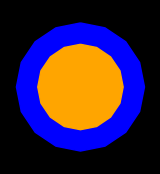

,x_min,y_min,x_max,y_max,max,min
0,1.0,1.0,1.0,1.0,1.0,0.98


In [11]:
a, b = contains_example1()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)


Expected Margins: 0.5 cm in all directions.


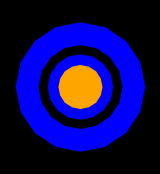

,x_min,y_min,x_max,y_max,max,min
0,0.5,0.5,0.5,0.5,0.51,0.49


In [12]:
a, b = contains_example2()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)

Expected Margins: 0.5 cm in all directions.


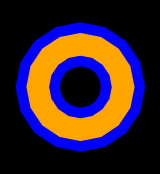

,x_min,y_min,x_max,y_max,max,min
0,0.5,0.5,0.5,0.5,0.5,0.49


In [13]:
a, b = contains_example3()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)

Expected Margins:
	-X: 2.7	+X: 0.3	y: < 1.5


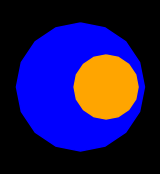

,x_min,y_min,x_max,y_max,max,min
0,2.7,1.24,0.3,1.24,2.7,0.29


In [14]:
a, b = contains_example4()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)

Expected Margins:
	-X: 2.0<1.0	+X: <1.0	-y: < 2.5	+y: < 0.5


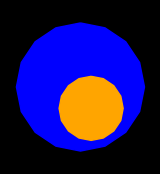

,x_min,y_min,x_max,y_max,max,min
0,1.8,0.4,0.8,2.4,2.61,0.36


In [15]:
a, b = contains_example5()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)

Expected Margins:
 	-X:  0.5	+X:  0.5  	-y: 0.5  	+y: 0.5	
	-X:  0.5	+X:  0.5  	-y: 0.5  	+y: 0.5	
	-X: <1.5	+X: <1.5  	-y: 0.5  	+y: 2.5	
	-X: <1.0	+X: <1.0  	-y: 1.5  	+y: 0.5	


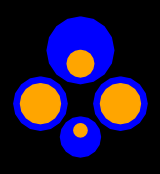

,x_min,y_min,x_max,y_max,max,min
0,0.50,0.5,0.50,0.5,0.5,0.49
1,0.50,0.5,0.50,0.5,0.5,0.49
2,1.28,0.5,1.28,2.5,2.5,0.49
3,0.90,1.5,0.90,0.5,1.5,0.49


In [16]:
a, b = contains_example6()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)

#### Surrounds

<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Surrounds</th><th>Transitive</t></tr>
<td class="d" colspan="2">
<span class="a">a</span> and <span class="b">b</span> have no interior points in common, and with holes filled <span class="b">b</span> lies in the interior of <span class="a">a</span>.
</td></tr><tr><td colspan="2">
<img src="Images/Relationships/surrounds simple.png" alt="surrounds simple">
<img src="Images/Relationships/surrounds with ring.png" alt="surrounds ring">
</td></tr>
</table></td></tr></table>


In [17]:
def surrounds_example1():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle2 = shapely.Polygon(circle_points(1))

    a = StructureSlice([circle6, circle4])
    b = StructureSlice([circle2])
    print('Expected Margins: 1 cm in all directions.', )
    return a, b

def surrounds_example2():
    circle6 = shapely.Polygon(circle_points(3))
    circle5 = shapely.Polygon(circle_points(2.5))
    circle4 = shapely.Polygon(circle_points(2))
    circle3 = shapely.Polygon(circle_points(1.5))
    circle2 = shapely.Polygon(circle_points(1))

    a = StructureSlice([circle6, circle5, circle2])
    b = StructureSlice([circle4, circle3])
    print('Expected Margins: 0.5 cm in all directions.', )
    return a, b

def surrounds_example3():
    box10x5 = shapely.Polygon(box_points(10,5))
    circle4_left = shapely.Polygon(circle_points(2, offset_x=-3))
    circle3_right = shapely.Polygon(circle_points(1.5, offset_x=3))
    circle2_left = shapely.Polygon(circle_points(1, offset_x=-3, offset_y=0.5))
    circle2_right = shapely.Polygon(circle_points(1, offset_x=3))
    a = StructureSlice([box10x5, circle4_left, circle3_right, circle2_right])
    b = StructureSlice([circle2_left])
    print('Expected Margins:\n\tX: < 1.0\t-Y: 1.5  \t+y: < 0.5', )
    return a, b

Expected Margins: 1 cm in all directions.


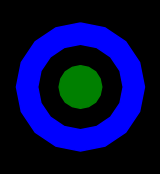

,x_min,y_min,x_max,y_max,max,min
0,1.0,1.0,1.0,1.0,1.0,0.97


In [18]:
a, b = surrounds_example1()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)


Expected Margins: 0.5 cm in all directions.


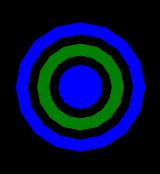

,x_min,y_min,x_max,y_max,max,min
0,0.5,0.5,0.5,0.5,0.51,0.49


In [19]:
a, b = surrounds_example2()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)

Expected Margins:
	X: < 1.0	-Y: 1.5  	+y: < 0.5


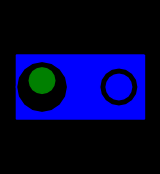

,x_min,y_min,x_max,y_max,max,min
0,0.9,1.5,0.9,0.5,1.5,0.49


In [20]:
a, b = surrounds_example3()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)

#### Shelters

<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Shelters</th><th>Transitive</th></tr>
<td class="d" colspan="2">
<span class="a">a</span> and <span class="b">b</span> 
have no points in common, 
but the Convex Hull of <span class="a">a</span> contains <span class="b">b</span>.
</td></tr>
<tr><td colspan="2">
<img src="Images/Relationships/shelters.png" alt="Shelters">
</td></tr>
</table></td></tr></table>

In [35]:
def shelters_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle5 = shapely.Polygon(circle_points(2.5))
    circle4_offset = shapely.Polygon(circle_points(2, offset_x=3.5))
    shell = shapely.difference(circle6, circle5)
    cove = shapely.difference(shell, circle4_offset)
    circle2 = shapely.Polygon(circle_points(1, offset_x=1))

    x_min_margin = 5.0/2 - 2.0/2 + 1.0   # Margin to contour
    cove_edge = cove.bounds[2]
    x_max_margin = cove_edge - 2.0/2 - 1.0   # Margin to Hull
    y_edge = sqrt(2.5*2.5 - 1)
    y_margin = y_edge - 2.0/2
    print(''.join([
        f'Expected Margins:\n\t',
        f'-X: {x_min_margin:3.2f}  ',
        f'+X:{x_max_margin:3.2f}  ',
        f'Y: {y_margin:3.2f}'
        ]))

    a = StructureSlice([cove])
    b = StructureSlice([circle2])

    return a, b


Expected Margins:
	-X: 2.50  +X:0.44  Y: 1.29


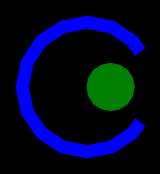

,x_min,y_min,x_max,y_max,max,min
0,2.5,1.28,0.44,1.28,2.5,0.44


In [36]:
a, b = shelters_example()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
margins(a, b, relation)

## Distance
- $Distance = distance(a,b)$

**Used By:**
- Disjoint


In [23]:
def distances(poly_a: StructureSlice, poly_b: StructureSlice,
              relation: RelationshipType,
              precision: int = PRECISION)->pd.DataFrame:
    distance_list = []
    # Compare all polygons on the same slice
    for polygon_a, polygon_b in product(poly_a.contour.geoms,
                                        poly_b.contour.geoms):
        boundary_a = polygon_a.exterior
        boundary_b = polygon_b.exterior
        distance = boundary_a.distance(boundary_b)
        rounded_distance = round(distance, precision)
        distance_dict = {'distance': rounded_distance}
        distance_list.append(distance_dict)
    if distance_list:
        return pd.DataFrame(distance_list)
    return pd.DataFrame()

### Distance Tests

#### Disjoint

<link rel="stylesheet" href="relations.css">
<table width="300px">
<tr class="l"><th>Disjoint</th><th>Symmetric</th></tr>
<td class="d" colspan="2">The Convex Hull of 
<span class="a">a</span> has no points in common with <span class="b">b</span>.</td></tr>
<tr><td colspan="2">
<img src="Images/Relationships/disjoint.png" alt="Disjoint" style="width: 200px">
</td></tr></table>

In [24]:
def disjoint_example():
    circle4_left = shapely.Polygon(circle_points(4, offset_x=-4.5))
    circle4_right = shapely.Polygon(circle_points(4, offset_x=4.5))

    a = StructureSlice([circle4_left])
    b = StructureSlice([circle4_right])
    print('Expected Distance: 1.0')
    return a, b


Expected Distance: 1.0


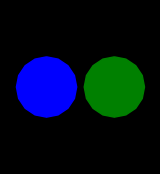

,distance
0,1.0


In [25]:
a, b = disjoint_example()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
distances(a, b, relation)

## Ratio of Volumes

Ratio of the overlapping volume to the average or larger volume.
$R_V =\frac{V( a \cap b )}{\overline{V_{a,b}}}$

Since the structures are compared slice by slice, the Volume function can be written as:<br>
$V(x) = t \times \operatorname{area} ( x )$,<br>
where $t$ is the slice thickness. 

When calculating the ratio, slice thickness is a constant, so the Volume ratio is equal to the ratio sums of the areas over all slices:
  
$R_V =\frac{\sum_s \operatorname{area}( a \cap b )}{\sum_s \overline{\operatorname{area}_{a,b}}}$

*Used By:*

- **Overlaps**
> - Ratio of the volume of overlap to the average volume of $a$ and $b$:
> - $R_v =\frac{\sum_s \left[ 2 \times \operatorname{area}( a \cap b ) \right] }{\sum_s \left[ \operatorname{area}( a ) + \operatorname{area}( b ) \right] }$


- **Partition**
> - Ratio of the volume of the overlap to the volume of the larger structure ($a$):
> - $R_V =\frac{\sum_s \operatorname{area}( a \cap b )}{\sum_s \operatorname{area}( a )}$


In [26]:
def related_areas(poly_a: StructureSlice,
                  poly_b: StructureSlice)->pd.DataFrame:
    area_list = []
    # Compare all polygons on the same slice
    for polygon_a, polygon_b in product(poly_a.contour.geoms,
                                        poly_b.contour.geoms):
        overlap_region = shapely.intersection(polygon_a, polygon_b)
        # FIXME This results in areas being counted more than once.
        area_dict = {'overlap': overlap_region.area,
                     'poly_a': polygon_a.area,
                     'poly_b': polygon_b.area}
        area_list.append(area_dict)
    if area_list:
        return pd.DataFrame(area_list)
    return pd.DataFrame()

In [27]:
def volume_ratio(poly_a: StructureSlice, poly_b: StructureSlice,
                 relation: RelationshipType,
                 precision: int = PRECISION)->pd.DataFrame:

    def average_volume_ratio(areas: pd.DataFrame,
                             precision: int = PRECISION)->pd.DataFrame:
        total_volume = areas.apply(sum)
        average_volume = (total_volume.poly_a + total_volume.poly_b) / 2.0
        ratio = total_volume.overlap / average_volume
        rounded_ratio = round(ratio, precision)
        return rounded_ratio

    def larger_area_ratio(areas: pd.DataFrame,
                          precision: int = PRECISION)->pd.DataFrame:
        total_areas = areas.apply(sum)
        ratio = total_areas.overlap / total_areas.poly_a
        rounded_ratio = round(ratio, precision)
        return rounded_ratio

    areas = related_areas(poly_a, poly_b)
    if relation == RelationshipType.OVERLAPS:
        ratio = average_volume_ratio(areas, precision)
    elif relation == RelationshipType.PARTITION:
        ratio = larger_area_ratio(areas, precision)
    else:
        ratio = np.nan
    return ratio

<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Overlaps</th><th>Symmetric</th></tr>
<td class="d" colspan="2">
<span class="a">a</span> and <span class="b">b</span> 
have some but not all points in common.
</td></tr>
<tr><td colspan="2">
<img src="Images/Relationships/overlaps simple.png" alt="Overlaps">
<img src="Images/Relationships/overlaps ring.png" alt="Overlaps With Ring">
<img src="Images/Relationships/overlaps surounded.png" alt="Overlaps Surrounded">
<img src="Images/Relationships/overlaps ring surrounds simple.png" alt="Ring Overlaps Simple">
<img src="Images/Relationships/archipelago contains simple.png" alt="Ring Overlaps Simple">
</td></tr></table>

In [32]:
def overlaps_box_example():
    box4 = shapely.Polygon(box_points(4))
    box4_offset = shapely.Polygon(box_points(4, offset_x=2))

    area_a = 4 * 4
    area_b = 4 * 4
    average_area = (area_a + area_b) / 2
    overlapping_area = 4 * 2
    ratio = overlapping_area / average_area
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([box4])
    b = StructureSlice([box4_offset])
    return a, b

def overlaps_simple_example():
    circle6 = shapely.Polygon(circle_points(3))
    box6_offset = shapely.Polygon(box_points(6, offset_x=3))

    area_a = pi * 3**2
    area_b = 6 * 6
    average_area = (area_a + area_b) / 2
    overlapping_area = area_a / 2
    ratio = overlapping_area / average_area
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([circle6])
    b = StructureSlice([box6_offset])
    return a, b

def overlaps_ring_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    box6_offset = shapely.Polygon(box_points(6, offset_x=3))

    area_a = pi * (3**2 - 2**2)
    area_b = 6 * 6
    average_area = (area_a + area_b) / 2
    overlapping_area = area_a / 2
    ratio = overlapping_area / average_area
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([circle6, circle4])
    b = StructureSlice([box6_offset])
    return a, b

def overlaps_surrounded_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle3_offset = shapely.Polygon(circle_points(1.5, offset_x=1))

    area_a = pi * (3**2 - 2**2)
    area_b = pi * ((3 / 2) ** 2)
    average_area = (area_a + area_b) / 2
    overlapping_area = area_b / 5  # Estimated 1/5 of smaller circle overlaps
    ratio = overlapping_area / average_area
    print(f'Estimated Ratio: {ratio:3.2f}')

    a = StructureSlice([circle6, circle4])
    b = StructureSlice([circle3_offset])
    return a, b

def overlaps_surrounded_box_example():
    box6 = shapely.Polygon(box_points(6))
    box4 = shapely.Polygon(box_points(4))
    box3 = shapely.Polygon(box_points(3, offset_x=1))

    area_a = 6*6 - 4*4
    area_b = 3 * 3
    average_area = (area_a + area_b) / 2
    overlapping_area = 3 * (3/2 -1)
    ratio = overlapping_area / average_area
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([box6, box4])
    b = StructureSlice([box3])
    return a, b

def overlaps_ring_surrounded_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle3 = shapely.Polygon(circle_points(1.5))
    circle4 = shapely.Polygon(circle_points(2))

    area_a = pi * (3**2 - 1.5**2)
    area_b = pi * 2**2
    average_area = (area_a + area_b) / 2
    overlapping_area = pi * (2**2 - 1.5**2)
    ratio = overlapping_area / average_area
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([circle6, circle3])
    b = StructureSlice([circle4])
    return a, b

def overlaps_archipelago_simple_example1():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle3 = shapely.Polygon(circle_points(1.5))
    circle2 = shapely.Polygon(circle_points(1))

    area_a = pi * (3**2 - 2**2 + 1**2)
    area_b = pi * 2**2
    average_area = (area_a + area_b) / 2
    overlapping_area = pi * (2**2 - 2**2 + 1**2)
    ratio = overlapping_area / average_area
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([circle6, circle4, circle2])
    b = StructureSlice([circle4])
    return a, b

def overlaps_archipelago_simple_example2():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle3 = shapely.Polygon(circle_points(1.5))
    circle2 = shapely.Polygon(circle_points(1))

    area_a = pi * (3**2 - 1.5**2 + 1**2)
    area_b = pi * 2**2
    average_area = (area_a + area_b) / 2
    overlapping_area = pi * (2**2 - 1.5**2 + 1**2)
    ratio = overlapping_area / average_area
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([circle6, circle3, circle2])
    b = StructureSlice([circle4])
    return a, b

Expected Ratio: 0.20


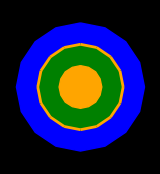

0.14


In [51]:
a, b = overlaps_archipelago_simple_example1()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))

In [54]:
areas = related_areas(a, b)
areas

,overlap,poly_a,poly_b
0,0.0000,15.3100,12.2276
1,3.0536,3.0536,12.2276


In [55]:
total_areas = areas.apply(sum)
total_areas

overlap     3.0536
poly_a     18.3636
poly_b     24.4552
dtype: float64

# poly_b area counted twice

In [56]:
area_a = pi * (3**2 - 2**2 + 1**2)
area_a


18.84955592153876

In [57]:
area_b = pi * 2**2
area_b


12.566370614359172

In [58]:
overlapping_area = pi * (2**2 - 2**2 + 1**2)
overlapping_area

3.141592653589793

Expected Ratio: 0.47


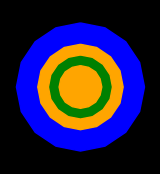

0.35


In [34]:
a, b = overlaps_archipelago_simple_example2()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))

Expected Ratio: 0.50


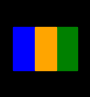

0.5


In [143]:
a, b = overlaps_box_example()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))


Expected Ratio: 0.44


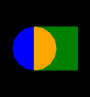

0.43


In [144]:
a, b = overlaps_simple_example()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))


Expected Ratio: 0.30


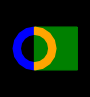

0.3


In [145]:
a, b = overlaps_ring_example()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))

Estimated Ratio: 0.12


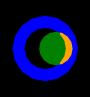

0.11


In [151]:
a, b = overlaps_surrounded_example()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))

Expected Ratio: 0.10


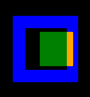

0.1


In [152]:
a, b = overlaps_surrounded_box_example()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))

Expected Ratio: 0.33


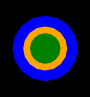

0.32


In [154]:
a, b = overlaps_ring_surrounded_example()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, 2))

# Check calculation
- Expected Ratio = 0.33
- Got: 0.32

*Is this rounding error?*

Expected Ratio: 0.47


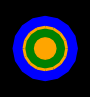

0.14


In [158]:
a, b = overlaps_archipelago_simple_example1()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))

Expected Ratio: 0.47


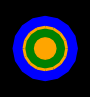

0.14


In [ ]:
a, b = overlaps_archipelago_simple_example2()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))

# Calculation Error
- Expected Ratio = 0.6
- Got: 0.14

*Probably did not include inner island or hole*

<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Partition</th><th></th></tr>
<td class="d" colspan="2">
The boundaries of <span class="a">a</span> and <span class="b">b</span> have more than one point in common.
No points of <span class="b">b</span> are exterior to <span class="a">a</span>, and some points in <span class="a">a</span> are exterior to <span class="b">b</span>.
</td></tr>
<tr><td colspan="2">
<img src="Images/Relationships/partitions simple.png" alt="Partition">
<img src="Images/Relationships/partitions archipelago with island.png" alt="Partition With Island">
<img src="Images/Relationships/partitions partial ring.png" alt="Partition Ring">
</td></tr></table>

In [113]:
def partition_simple_example():
    box4 = shapely.Polygon(box_points(4))
    box4_cropped = shapely.Polygon(box_points(2, 4, offset_x=-1))

    larger_area = 4**2
    overlapping_area = 4**2 / 2
    ratio = overlapping_area / larger_area
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([box4])
    b = StructureSlice([box4_cropped])
    return a, b

def partition_example1():
    box6 = poly_round(shapely.Polygon(box_points(6)))
    box4_offset = shapely.Polygon(box_points(4, offset_x=-1))

    larger_area = 6**2
    overlapping_area = 4**2
    ratio = overlapping_area / larger_area
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([box6])
    b = StructureSlice([box4_offset])
    return a, b

def partition_example2():
    # Rounding required because of floating point inaccuracies.
    circle6 = poly_round(shapely.Polygon(circle_points(3)))
    circle4_offset = shapely.Polygon(circle_points(2, offset_x=2))
    cropped_circle = poly_round(shapely.intersection(circle6, circle4_offset))
    # Larger Area = pi*3^2 = 28.3
    # Overlap Area ~ pi*2^2*.6 = 16
    # Ratio ~ 16 / 28.3 = 0.3
    larger_area = pi * 3**2
    overlapping_area = pi * 2**2 * 0.75  # Approximately 3/4 of smaller circle
    ratio = overlapping_area / larger_area
    print(f'Estimated Ratio: {ratio:3.2f}')

    a = StructureSlice([circle6])
    b = StructureSlice([cropped_circle])
    return a, b

def partition_example3():
    # Partition is island part of archipelago
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle2 = shapely.Polygon(circle_points(1))

    larger_area = pi * (3**2 - 2**2 + 1**2)
    overlapping_area = pi * 1**2
    ratio = overlapping_area / larger_area
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([circle6, circle4, circle2])
    b = StructureSlice([circle2])
    return a, b

def partition_example4():
    # Partition is half of ring
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    box6_offset = shapely.Polygon(box_points(6, offset_x=3))
    ring = shapely.difference(circle6, circle4)
    cropped_ring = poly_round(shapely.difference(ring, box6_offset),PRECISION)

    larger_area = pi * (3**2 - 2**2)
    overlapping_area = pi * (3**2 - 2**2) / 2
    ratio = overlapping_area / larger_area
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([circle6, circle4])
    b = StructureSlice([cropped_ring])
    return a, b

Expected Ratio: 0.50


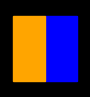

0.5


In [104]:
a, b = partition_simple_example()
ax = plot_ab(a.contour, b.contour)

relation_binary = relate(a,b)
relation = identify_relation(relation_binary)

print(volume_ratio(a, b, relation, PRECISION))

Expected Ratio: 0.44


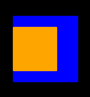

0.44


In [105]:
a, b = partition_example1()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))

Estimated Ratio: 0.33


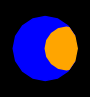

0.33


In [114]:
a, b = partition_example2()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))

Expected Ratio: 0.17


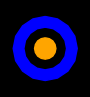

0.17


In [107]:
a, b = partition_example3()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))

Expected Ratio: 0.50


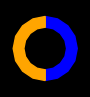

0.5


In [108]:
a, b = partition_example4()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(volume_ratio(a, b, relation, PRECISION))

## Ratio of Surface Area

Ratio of the touching surface area of the two structures, to the surface area of the average or larger structure.
$R_A =\frac{A( a \cap b )}{\overline{A_{a,b}}}$,<br>
where $A$ is the Surface Area. 

Since the structures are compared slice by slice, the Surface Area function can be written as:<br>
$A(x) = t \times \ell_s( x )$,<br>
where $t$ is the slice thickness and $\ell_s$ is the relevant perimeter length on a given slice. 

When calculating the ratio, slice thickness is a constant, so the surface area ratio is equal to the ratio sums of the relevant perimeter lengths over all slices:
  
$R_A =\frac{\sum_{S} \ell_s( a \cap b )}{\sum_{S} \overline{\ell_s}}$

*Used By:*

- Exterior Borders
> - Ratio of the length of the touching exterior perimeters to the average length of the exterior perimeters of $a$ and $b$.
> - $R_A = \frac{ 2 \sum_{S} \ell_s⁡(a_p \cap b_p) }{ \sum_{S} \left[ \ell_s(a_{px}) + \ell_s(b_{px}) \right] }$

- Interior Borders
> - Ratio of the length of touching perimeters to the length of the perimeter of the hole in $a$ containing $b$.
> - $R_l = \frac{ \sum_{S} \ell_s⁡(a_p \cap b_p)}{ \sum_{S} \left[ \ell_s(a_{ph}) + \ell_s(b_{px}) \right] }$

Where:
- $a_p$ is the perimeter of polygon $a$
- $b_p$ is the perimeter of polygon $b$
- $a_{px}$ is the exterior perimeter of polygon $a$
- $b_{px}$ is the exterior perimeter of polygon $b$
- $a_{ph}$ is the perimeter of the relevant hole within polygon $a$
- $\ell_s⁡(p_i)$ is the length of perimeter $i$ on slice $s$


In [89]:
def related_lengths(poly_a: StructureSlice, poly_b: StructureSlice,
                    relation: RelationshipType)->List[shapely.LineString]:
    def get_perimeters(poly_a: StructureSlice, poly_b: StructureSlice):
        exterior_a = poly_a.exterior
        exterior_b = poly_b.exterior
        overlap_region = shapely.shared_paths(exterior_a, exterior_b)
        perimeter_dict = {'overlapping_perimeter': overlap_region,
                          'perimeter_a': exterior_a,
                          'perimeter_b': exterior_b}
        return perimeter_dict

    perimeter_list = []
    # get relevant perimeters for all polygons on the same slice
    for polygon_a, polygon_b in product(poly_a.contour.geoms,
                                        poly_b.contour.geoms):
        if relation == RelationshipType.BORDERS:
            perimeter_dict = get_perimeters(polygon_a, polygon_b)
            perimeter_list.append(perimeter_dict)
        elif relation == RelationshipType.BORDERS_INTERIOR:
            # TODO Need to be able to identify which hole in a contains b even for
            # slices where b is not present. For now we use the perimeter of all
            # holes in a as a reasonable approximation.
            for hole_ring in polygon_a.interiors:
                hole = shapely.Polygon(hole_ring)
                perimeter_dict = get_perimeters(hole, polygon_b)
                perimeter_list.append(perimeter_dict)
    return perimeter_list


In [90]:
def length_ratio(poly_a: StructureSlice, poly_b: StructureSlice,
                 relation: RelationshipType,
                 precision: int = PRECISION)->pd.DataFrame:

    def get_length(perimeter: shapely.LineString)->float:
        return shapely.length(perimeter)

    perimeter_list = related_lengths(poly_a, poly_b, relation)
    if not perimeter_list:
        return np.nan
    perimeters = pd.DataFrame(perimeter_list)
    lengths = perimeters.apply(get_length)
    lengths_sum = lengths.apply(sum)
    if relation == RelationshipType.BORDERS:
        total_length = (lengths_sum.perimeter_a + lengths_sum.perimeter_b)
        reference_length = total_length / 2
    elif relation == RelationshipType.BORDERS_INTERIOR:
        reference_length = lengths_sum.perimeter_a
    ratio = lengths_sum.overlapping_perimeter / reference_length
    rounded_ratio = round(ratio, precision)
    return rounded_ratio

<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Borders</th><th>Symmetric</th></tr>
<td class="d" colspan="2">The exterior boundaries of 
<span class="a">a</span> and <span class="b">b</span> 
have more than one point in common, but their interiors do not intersect.
</td></tr>
<tr><td colspan="2">
<img src="Images/Relationships/borders.png" alt="Borders">
<img src="Images/Relationships/Concave Borders.png" alt="Concave Borders">
</tr></table>

In [91]:
def borders_example1():
    box4_left = shapely.Polygon(box_points(4, offset_x=-2))
    box4_right = shapely.Polygon(box_points(4, offset_x=2))

    a = StructureSlice([box4_left])
    b = StructureSlice([box4_right])
    average_perimeter = 4 * 4
    overlapping_perimeter = 4
    ratio = overlapping_perimeter / average_perimeter
    print(f'Expected Ratio: {ratio:3.2f}')
    return a, b

def borders_example2():
    box6 = shapely.Polygon(box_points(6))
    box5_up = shapely.Polygon(box_points(5, offset_y=3))
    box6_cropped = shapely.difference(box6, box5_up)

    box6_cropped_perimeter = 6 * 4 + (5/2) * 2
    box5_up_perimeter = 5 * 4
    average_perimeter = (box6_cropped_perimeter + box5_up_perimeter) / 2.0
    overlapping_perimeter = 5 + (5/2) * 2
    ratio = overlapping_perimeter / average_perimeter
    print(f'Expected Ratio: {ratio:3.2f}')
    a = StructureSlice([box6_cropped])
    b = StructureSlice([box5_up])
    return a, b

Expected Ratio: 0.25


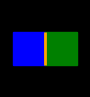

0.25


In [92]:
a, b = borders_example1()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(length_ratio(a, b, relation, PRECISION))

Expected Ratio: 0.41


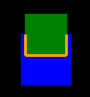

0.41


In [93]:
a, b = borders_example2()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(length_ratio(a, b, relation, PRECISION))

<link rel="stylesheet" href="relations.css">
<table width="300px">
<tr class="l"><th>Borders_Interior</th><th>Symmetric</th></tr>
<td class="d" colspan="2">The interior boundary of <span class="a">a</span> 
and the exterior boundary of <span class="b">b</span> 
have more than one point in common, but their interiors do not intersect.
<tr><td colspan="2">
<img src="Images/Relationships/confines.png" alt="Borders Interior">
<img src="Images/Relationships/confines with island.png" alt="Borders Interior With Island">
</td></tr></table>

In [94]:
def interior_borders_example1():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    box4_offset = shapely.Polygon(box_points(4, offset_x=2))
    cropped_circle = shapely.difference(circle4, box4_offset)

    hole_perimeter = 4 * pi
    overlapping_perimeter = 4 * pi / 2
    ratio = overlapping_perimeter / hole_perimeter
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([circle6, circle4])
    b = StructureSlice([cropped_circle])
    return a, b

def interior_borders_example2():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle2 = shapely.Polygon(circle_points(1))

    # b has internal borders with the ring portion of a, but has an external
    # border with the island part of a. The internal borders relation wins,
    # but the island perimeter is not considered in the ratio.
    hole_perimeter = 4 * pi
    overlapping_perimeter = 4 * pi
    ratio = overlapping_perimeter / hole_perimeter
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([circle6, circle4, circle2])
    b = StructureSlice([circle4, circle2])
    return a, b

def interior_borders_example3():
    # 6 cm x 6 cm box with 4cm x 4 cm hole
    box6 = shapely.Polygon(box_points(6))
    box4 = shapely.Polygon(box_points(4))
    box2_offset = shapely.Polygon(box_points(2, offset_x=-1, offset_y=-1))

    hole_perimeter = 4 * 4
    overlapping_perimeter = 2 * 2
    ratio = overlapping_perimeter / hole_perimeter
    print(f'Expected Ratio: {ratio:3.2f}')

    a = StructureSlice([box6, box4])
    b = StructureSlice([box2_offset])
    return a, b

Expected Ratio: 0.50


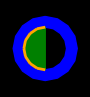

0.5


In [95]:
a, b = interior_borders_example1()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(length_ratio(a, b, relation, PRECISION))

Expected Ratio: 1.00


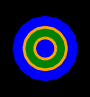

1.0


In [96]:
a, b = interior_borders_example2()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(length_ratio(a, b, relation, PRECISION))

Expected Ratio: 0.25


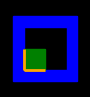

0.25


In [97]:
a, b = interior_borders_example3()
ax = plot_ab(a.contour, b.contour)
relation_binary = relate(a,b)
relation = identify_relation(relation_binary)
print(length_ratio(a, b, relation, PRECISION))